# Libraries

In [1]:
require(plyr)
require(tableone)
require(gamm4)
require(MuMIn)
require(ggplot2)
require(tidyr)
require(stringr)
require(gridExtra)
require(lmtest)
library(reshape)
require(boot)

Loading required package: plyr
Loading required package: tableone
Loading required package: gamm4
Loading required package: Matrix
Loading required package: lme4
Loading required package: mgcv
Loading required package: nlme

Attaching package: 'nlme'

The following object is masked from 'package:lme4':

    lmList

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
This is gamm4 0.2-5

Loading required package: MuMIn
Registered S3 method overwritten by 'MuMIn':
  method         from
  predict.merMod lme4
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: tidyr

Attaching package: 'tidyr'

The following object is masked from 'package:Matrix':

    expand

Loading required package: stringr
Loading required package: gridExtra
Loading required package: lmtest
Loading required package: zoo

Attaching package: 'zoo'

The following ob

# Read Data:

- NDA file
- Polygenic Scores
- Genetic Ancestry Factors
- PCs

In [2]:
# File paths
nda_file = '/path/to/nda/nda2.0.1.Rds'
prs_file = '/path/to/prs/merged_prs_scores.tsv'
ancestry_file = '/path/to/ancestry/Genetic_Ancestry_Factors.4.txt'
pcs_file = '/path/to/pcs/plink2.eigenvec'

# Read demographics and assesments
df = readRDS(nda_file)
df = df[df$eventname=='baseline_year_1_arm_1', ] # Subset on baseline data
# Read Polygenic Scores
prs = read.table(prs_file, header=TRUE)
# Read Genetic Ancestry Factors
ancestry = read.table(ancestry_file, header=TRUE)
colnames(ancestry)[colnames(ancestry)=='IID'] = 'src_subject_id'
# Read PCs
pcs = read.table(pcs_file, header=TRUE)
colnames(pcs)[colnames(pcs)=='IID'] = 'src_subject_id'

In [3]:
# Reformat PRS ids to enable matching with nda file
reformat_id <- function(id){
    ans = unlist(strsplit(id, 'NDAR_'))[2]
    ans = paste0('NDAR_', unlist(strsplit(ans, '_'))[1])
    return(ans)
}
colnames(prs)[1] = 'src_subject_id'
# Reformat IDs to have correct congruant format with NDA
reformated_rows = lapply(as.character(prs$src_subject_id), reformat_id)
prs = prs[!duplicated(reformated_rows),]
prs$src_subject_id = reformated_rows[!duplicated(reformated_rows)]
# Rename polygenic scores to have suffix '_PS'
colnames(prs)[2:dim(prs)[2]] = paste0(colnames(prs)[2:dim(prs)[2]], '_PS')

# Join Data Frames Together

In [4]:
df = join(df, prs, type='left')
df = join(df, ancestry, by='src_subject_id')
df = join(df, pcs, by='src_subject_id')

Joining by: src_subject_id


# Rename and Reorder Factors

In [5]:
# Rename cols
colnames(df)[colnames(df) == 'high.educ'] = 'Parent.Educ'
colnames(df)[colnames(df) == 'household.income'] = 'Household.Income'
colnames(df)[colnames(df) == 'age'] = 'Age'
colnames(df)[colnames(df) == 'sex'] = 'Gender'
colnames(df)[colnames(df) == 'married'] = 'ParentMarried'
# Reorder factors
df$Parent.Educ = factor(df$Parent.Educ, levels=c('< HS Diploma','HS Diploma/GED','Some College','Bachelor','Post Graduate Degree'))
df$Household.Income = factor(df$Household.Income, levels=c('[<50K]', '[>=50K & <100K]', '[>=100K]'))

# Define Model Variables and Report Missingness

In [6]:
poly_score = 'IQ_PS'
nihtbx_names = colnames(df)[startsWith(colnames(df), 'nihtbx') & endsWith(colnames(df), 'uncorrected')]
ancestry_groups = colnames(ancestry)[c(2,4,5)]
pc_cols = paste0('PC', seq(10))
non_gen_covars = c('Gender', 'ParentMarried', 'Age', 'Parent.Educ', 'Household.Income')
covariates = c(non_gen_covars, pc_cols)#, ancestry_groups)
covariate_str = paste(covariates, collapse=' + ')
ran = '~(1|abcd_site/rel_family_id)'

In [7]:
missing_demo_tlbx = rowSums(is.na(df[, c(non_gen_covars, 'abcd_site', 'rel_family_id', nihtbx_names)]))>0
print(paste0('Number of missing individuals due to missing demographics or NIH_tlbx: ', toString(sum(missing_demo_tlbx))))
missing_household_income = is.na(df[, 'Household.Income'])
print(paste0('Of which individuals due to missing household income: ', toString(sum(missing_household_income))))
missing_genetics = (rowSums(is.na(df[, c(pc_cols, poly_score)]))>0 & !missing_demo_tlbx)
print(paste0('Additional number of individuals missing due to missing genetics: ', toString(sum(missing_genetics))))

[1] "Number of missing individuals due to missing demographics or NIH_tlbx: 1319"
[1] "Of which individuals due to missing household income: 1018"
[1] "Additional number of individuals missing due to missing genetics: 1414"


In [8]:
# Drop missing
df = df[rowSums(is.na(df[, c(covariates, poly_score, nihtbx_names, 'abcd_site', 'rel_family_id')]))==0, ]

# Print Table 1 Statistics

### Table 1 Full Sample

In [9]:
varList = c('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 'Age', 'Gender', 'ParentMarried', 'Parent.Educ', 'Household.Income', 'race_ethnicity')
ind = rowSums(is.na(df[, c(nihtbx_names, 'abcd_site', 'rel_family_id', covariates, poly_score)]))==0
tableone = CreateTableOne(vars = varList, data = df[ind, ])
tab1Mat <- print(tableone, exact = "stage", quote = FALSE, noSpaces = TRUE, printToggle = FALSE)
## Save to a CSV file
print(tab1Mat)

                                          
                                           Overall        
  n                                        "9142"         
  nihtbx_fluidcomp_uncorrected (mean (SD)) "92.11 (10.47)"
  nihtbx_cryst_uncorrected (mean (SD))     "86.84 (6.92)" 
  Age (mean (SD))                          "119.04 (7.47)"
  Gender = M (%)                           "4775 (52.2)"  
  ParentMarried = yes (%)                  "6436 (70.4)"  
  Parent.Educ (%)                          ""             
     < HS Diploma                          "339 (3.7)"    
     HS Diploma/GED                        "703 (7.7)"    
     Some College                          "2302 (25.2)"  
     Bachelor                              "2473 (27.1)"  
     Post Graduate Degree                  "3325 (36.4)"  
  Household.Income (%)                     ""             
     [<50K]                                "2553 (27.9)"  
     [>=50K & <100K]                       "2627 (28.7)"  
     [>=100K]

### Table 1 European Sample

In [10]:
EUR_ind = df$EUR > 0.9
varList = c('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 'Age', 'Gender', 'ParentMarried', 'Parent.Educ', 'Household.Income', 'race_ethnicity')
ind = rowSums(is.na(df[, c(nihtbx_names, 'abcd_site', 'rel_family_id', covariates, poly_score)]))==0
tableone = CreateTableOne(vars = varList, data = df[ind & EUR_ind, ])
tab1Mat <- print(tableone, exact = "stage", quote = FALSE, noSpaces = TRUE, printToggle = FALSE)
## Save to a CSV file
print(tab1Mat)

                                          
                                           Overall        
  n                                        "5212"         
  nihtbx_fluidcomp_uncorrected (mean (SD)) "93.95 (9.61)" 
  nihtbx_cryst_uncorrected (mean (SD))     "88.60 (6.28)" 
  Age (mean (SD))                          "119.19 (7.47)"
  Gender = M (%)                           "2751 (52.8)"  
  ParentMarried = yes (%)                  "4325 (83.0)"  
  Parent.Educ (%)                          ""             
     < HS Diploma                          "21 (0.4)"     
     HS Diploma/GED                        "150 (2.9)"    
     Some College                          "966 (18.5)"   
     Bachelor                              "1649 (31.6)"  
     Post Graduate Degree                  "2426 (46.5)"  
  Household.Income (%)                     ""             
     [<50K]                                "643 (12.3)"   
     [>=50K & <100K]                       "1587 (30.4)"  
     [>=100K]

### Table 1 Non-European Sample

In [11]:
nonEUR_ind = df$EUR < 0.9
varList = c('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 'Age', 'Gender', 'ParentMarried', 'Parent.Educ', 'Household.Income', 'race_ethnicity')
ind = rowSums(is.na(df[, c(nihtbx_names, 'abcd_site', 'rel_family_id', covariates, poly_score)]))==0
tableone = CreateTableOne(vars = varList, data = df[ind & nonEUR_ind, ])
tab1Mat <- print(tableone, exact = "stage", quote = FALSE, noSpaces = TRUE, printToggle = FALSE)
## Save to a CSV file
print(tab1Mat)

                                          
                                           Overall        
  n                                        "3930"         
  nihtbx_fluidcomp_uncorrected (mean (SD)) "89.67 (11.05)"
  nihtbx_cryst_uncorrected (mean (SD))     "84.50 (7.03)" 
  Age (mean (SD))                          "118.84 (7.46)"
  Gender = M (%)                           "2024 (51.5)"  
  ParentMarried = yes (%)                  "2111 (53.7)"  
  Parent.Educ (%)                          ""             
     < HS Diploma                          "318 (8.1)"    
     HS Diploma/GED                        "553 (14.1)"   
     Some College                          "1336 (34.0)"  
     Bachelor                              "824 (21.0)"   
     Post Graduate Degree                  "899 (22.9)"   
  Household.Income (%)                     ""             
     [<50K]                                "1910 (48.6)"  
     [>=50K & <100K]                       "1040 (26.5)"  
     [>=100K]

# Z score Continuous Variables

In [12]:
df[, c(nihtbx_names, pc_cols, poly_score, 'Age')] = scale(df[, c(nihtbx_names, pc_cols, poly_score, 'Age')])

In [13]:
model_table = data.frame(dependant_var=rep(nihtbx_names, length(poly_score)), 
           prs=rep(poly_score, each=length(nihtbx_names)))
model_table$full = paste0(model_table$dependant_var, ' ~ ', model_table$prs, ' + ', covariate_str)
model_table$reduced = paste0(model_table$dependant_var, ' ~ ', covariate_str)

In [14]:
gamm4_link = function(form, random, dat=df){
    return <- gamm4(formula=formula(form), random=formula(random), data=dat)
}

fit_gamm_models = function(dat, model_table, suffix, return_full_models=FALSE){
    full_models = mapply(gamm4_link, form=model_table$full, MoreArgs=list(random=formula(ran), dat=dat))
    if (return_full_models){
        return(full_models)
    }
    reduced_models = mapply(gamm4_link, form=model_table$reduced, MoreArgs=list(random=formula(ran), dat=dat))
    
    # Extract results
    for (i in 1:dim(model_table)[1]){
        dep_var = unlist(strsplit(toString(full_models[,i]$gam$formula), ', '))[2]
        ind = model_table$dependant_var %in% dep_var
        model_table[ind, paste0('PS_coeff', suffix)] = as.numeric(summary(full_models[,i]$gam)$p.coeff[2])
        model_table[ind, paste0('PS_coeff_SE', suffix)] = as.numeric(summary(full_models[,i]$gam)$se[2])
        model_table[ind, paste0('upper', suffix)] = as.numeric(summary(full_models[,i]$gam)$p.coeff[2]) + 1.96*as.numeric(summary(full_models[,i]$gam)$se[2])
        model_table[ind, paste0('lower', suffix)] = as.numeric(summary(full_models[,i]$gam)$p.coeff[2]) - 1.96*as.numeric(summary(full_models[,i]$gam)$se[2])
        model_table[ind, paste0('t', suffix)] = as.numeric(summary(full_models[,i]$gam)$p.t[2])
        model_table[ind, paste0('pval', suffix)] = summary(full_models[,i]$gam)$p.pv[[2]]
        model_table[ind, paste0('r2_delta', suffix)] = r.squaredLR(full_models[,i]$mer, reduced_models[,i]$mer)
        # Likelihood ratio test
        lrttest_table = anova(full_models[,i]$mer, reduced_models[,i]$mer)
        model_table[ind, paste0('lrt_chisq', suffix)] = lrttest_table['full_models[, i]$mer', 'Chisq']
        model_table[ind, paste0('lrt_pval', suffix)] = lrttest_table['full_models[, i]$mer', 'Pr(>Chisq)']
        model_table[ind, paste0('n_full', suffix)] = length(full_models[,i]$gam$residuals)
        model_table[ind, paste0('n_reduced', suffix)] = length(reduced_models[,i]$gam$residuals)
    }
    return (model_table)
}

# Fit Models

In [15]:
model_table = fit_gamm_models(dat=df, model_table=model_table, suffix='_full_samp')

refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)


In [16]:
# Remove total composite from table
ind = model_table$dependant_var %in% 'nihtbx_totalcomp_uncorrected'
model_table = model_table[!ind, ]

In [17]:
# Clean name and ordering of measures for plotting
simpleCap <- function(s) {paste(toupper(substring(s, 1,1)), substring(s, 2), sep="", collapse=" ")}
dep_var_nice_name = gsub('_uncorrected', '', gsub('nihtbx_', '', as.character(model_table$dependant_var)))
dep_var_nice_name = sapply(dep_var_nice_name, simpleCap)
dep_var_nice_name[dep_var_nice_name=='Picvocab'] = 'Picture Vocabulary'
dep_var_nice_name[dep_var_nice_name=='Fluidcomp'] = 'Fluid Composite'
dep_var_nice_name[dep_var_nice_name=='Cryst'] = 'Crystallized Composite'
ordering = c('Pattern', 'Picture', 'List', 'Flanker', 'Cardsort', 'Picture Vocabulary', 'Reading', 'Fluid Composite', 'Crystallized Composite')
model_table$dependant_var_nice_name = factor(dep_var_nice_name, levels=ordering)

In [18]:
# sort table to be ordered by crytalized and fluid
model_table = with(model_table, model_table[order(dependant_var_nice_name),])
model_table$pos = seq(1:dim(model_table)[1])

In [19]:
model_table$Composite = c(rep('Fluid',5), rep('Crystallized',2), 'Fluid', 'Crystallized')

In [20]:
# Seperate composite scores from individual measures
model_table$pos[(dim(model_table)[1]-1):dim(model_table)[1]] = model_table$pos[(dim(model_table)[1]-1):dim(model_table)[1]] + 1.20

In [21]:
row.names(model_table) = model_table$dependant_var

# Create figure 1 - Using Full Sample

In [22]:
across_toolbox_plot = function(model_table, sample_suffix, asterix_height, number_of_aterix, asterix_size, title, legend){
#     options(repr.plot.width=6, repr.plot.height=4)
    coeff_name = paste0("PS_coeff", sample_suffix)
    upper_col = paste0("upper", sample_suffix)
    lower_col = paste0("lower", sample_suffix)
    n = model_table['nihtbx_fluidcomp_uncorrected', paste0('n_full', sample_suffix)]
    title = paste0(title, ' \n(N=', n, ')')
    # Option for if legend is or isn't included
    if (legend){
       theme = theme(text = element_text(size=10), axis.text.x = element_text(angle = 45, hjust = 1), 
          legend.position = c(.05, .95),
    legend.justification = c("left", "top"),
    legend.box.just = "right",
    legend.box.background = element_rect(colour = "black"),
    legend.margin = margin(4, 5, 4, 5),
     legend.title=element_text(size=8), 
    legend.text=element_text(size=8), legend.key.size = unit(.7,"line")) 
    }else{
        theme = theme(text = element_text(size=10), axis.text.x = element_text(angle = 45, hjust = 1), 
          legend.position = "none")
    }
    p = ggplot(data=model_table, aes_string(x="pos", y=coeff_name, fill="Composite") )+
      geom_bar(color='black', aes(fill=Composite), stat="identity") + 
    xlab("") + ylab('Intelligence PS Standardized \n Regression Coefficient') + labs(title=title) + 
    geom_errorbar(data=model_table, mapping=aes_string(x="pos", ymin=upper_col, ymax=lower_col), width=0.2, size=1, color="blue") + 
    scale_x_continuous(labels = as.character(model_table$dependant_var_nice_name), breaks = model_table$pos) +
    guides(fill = guide_legend(reverse = TRUE)) + theme_bw() + 
    theme +  
    ylim(NA, 0.75)

    # # Add asterix
    if (!is.null(asterix_height)){
        label.df <- data.frame(pos = sum(model_table[c(8,9), 'pos'])/2, Composite='Fluid')
        label.df[, coeff_name] = c(asterix_height)

        # Add arc
        t <- seq(0, 180, by = 1) * pi / 180
        r <- .5
        x <- r * cos(t)
        y <- r*0.09 * sin(t)-0.02
        y[20:162] <- y[20] # Flattens the arc

        arc.df <- data.frame(pos = x, coeff = y, Composite='Fluid')
        asterix_label = paste(rep("*", number_of_aterix), collapse="")
        p = p + geom_line(data = arc.df, aes(pos+label.df$pos, coeff+label.df[, coeff_name]), lty = 1) +
        geom_text(data = label.df, label = asterix_label, size=asterix_size)
    }
    
    aspect_ratio=1
    return(p)
}

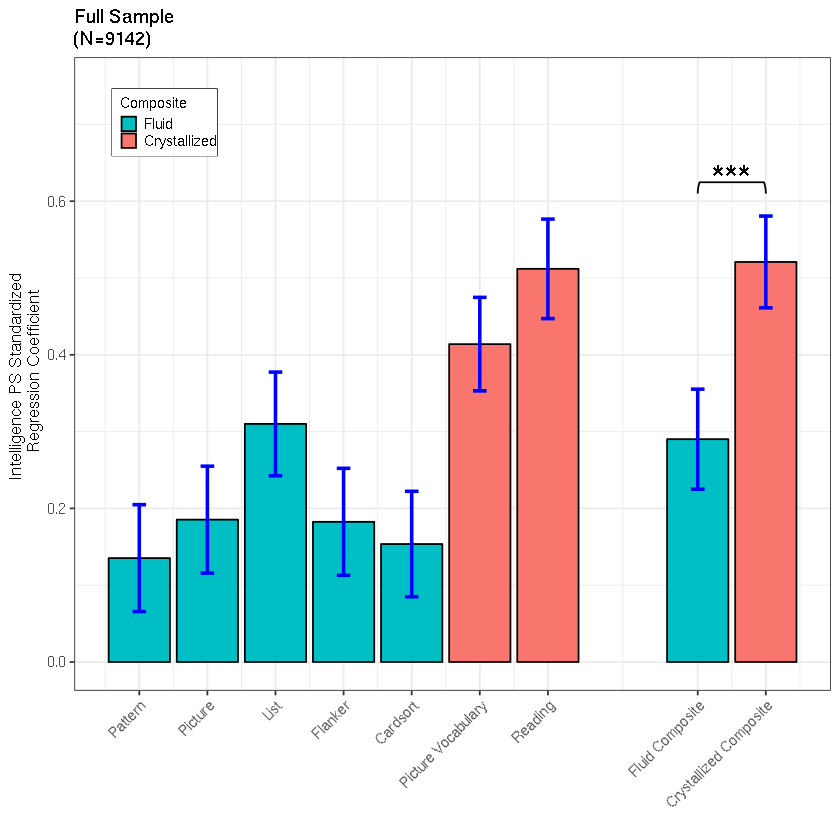

In [23]:
p1 = across_toolbox_plot(model_table, '_full_samp', asterix_height=0.63, number_of_aterix=3, asterix_size=8,
                         'Full Sample', legend=TRUE)
p1

### Perform Analysis in Stratified Samples of Europeans and African Ancestry Only

In [24]:
model_table = fit_gamm_models(df[EUR_ind, ], model_table, '_EUR')
model_table = fit_gamm_models(df[nonEUR_ind, ], model_table, '_nonEUR')

refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)


In [26]:
p2 = across_toolbox_plot(model_table, '_EUR', asterix_height=0.7, number_of_aterix=3, asterix_size=6,
                         'Europeans Only', legend=FALSE)
p3 = across_toolbox_plot(model_table, '_nonEUR', asterix_height=0.63, number_of_aterix=1, asterix_size=6, 
                         'Non-Europeans Only', legend=FALSE)

Saving 6.67 x 6.67 in image


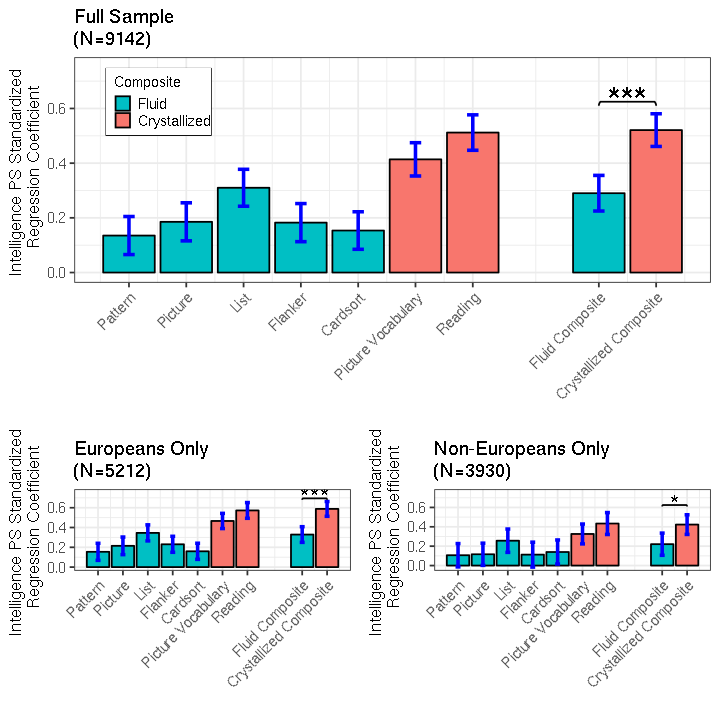

In [27]:
options(repr.plot.width=6, repr.plot.height=6)
tot_p = grid.arrange(
    p1,
    p2,
    p3,
    heights=c(1.8,1.2),
    layout_matrix = rbind(c(1, 1),
                        c(2, 3))
)
# tot_p
ggsave('figure_1.pdf', tot_p)

In [359]:
model_table[c(8,9),endsWith(colnames(model_table), 'full_samp')]

,PS_coeff_full_samp,PS_coeff_SE_full_samp,upper_full_samp,lower_full_samp,t_full_samp,pval_full_samp,r2_delta_full_samp,lrt_chisq_full_samp,lrt_pval_full_samp,anova_full_samp,n_full_full_samp,n_reduced_full_samp
nihtbx_fluidcomp_uncorrected,0.2901192,0.03323114,0.3552522,0.2249862,8.730342,2.987009e-18,0.00829027,76.10695,2.687102e-18,23,9142,9142
nihtbx_cryst_uncorrected,0.5208853,0.03049103,0.5806477,0.4611229,17.083229,1.976459e-64,0.03097809,287.67974,1.592671e-64,23,9142,9142


In [358]:
model_table[c(8,9),endsWith(colnames(model_table), 'EUR')]

,PS_coeff_EUR,PS_coeff_SE_EUR,upper_EUR,lower_EUR,t_EUR,pval_EUR,r2_delta_EUR,lrt_chisq_EUR,lrt_pval_EUR,anova_EUR,...,upper_nonEUR,lower_nonEUR,t_nonEUR,pval_nonEUR,r2_delta_nonEUR,lrt_chisq_nonEUR,lrt_pval_nonEUR,anova_nonEUR,n_full_nonEUR,n_reduced_nonEUR
nihtbx_fluidcomp_uncorrected,0.3289418,0.04041139,0.4081481,0.2497355,8.139829,4.912445e-16,0.01261010,66.14253,4.194659e-16,23,...,0.3349023,0.1060959,3.777676,1.606551e-04,0.003638176,14.32607,1.537208e-04,23,3930,3930
nihtbx_cryst_uncorrected,0.5882659,0.03824715,0.6632303,0.5133015,15.380645,3.087765e-52,0.04352649,231.94257,2.247543e-52,23,...,0.5243532,0.3215605,8.175790,3.931987e-16,0.016810220,66.62619,3.281972e-16,23,3930,3930


In [365]:
model_table[c(8,9),endsWith(colnames(model_table), 'nonEUR')]

,PS_coeff_nonEUR,PS_coeff_SE_nonEUR,upper_nonEUR,lower_nonEUR,t_nonEUR,pval_nonEUR,r2_delta_nonEUR,lrt_chisq_nonEUR,lrt_pval_nonEUR,anova_nonEUR,n_full_nonEUR,n_reduced_nonEUR
nihtbx_fluidcomp_uncorrected,0.2204991,0.05836898,0.3349023,0.1060959,3.777676,1.606551e-04,0.003638176,14.32607,1.537208e-04,23,3930,3930
nihtbx_cryst_uncorrected,0.4229568,0.05173284,0.5243532,0.3215605,8.175790,3.931987e-16,0.016810220,66.62619,3.281972e-16,23,3930,3930


## Save Full Table of Regression Results from Crystallized and Fluid

In [137]:
save_regression_results = function(df, model_table, suffix){
    full_models = fit_gamm_models(dat=df, model_table=model_table, suffix=suffix, return_full_models=TRUE)
    for (i in seq(1, dim(model_table)[1])){
        regression_res = summary(full_models[,i]$gam)
        behavior = str_replace(str_replace(model_table[i, 'dependant_var'], 'nihtbx_', ''), '_uncorrected', '')
        write.table(regression_res$p.table, paste0(suffix, '_', behavior, '.csv'), quote=FALSE, sep=',', col.names = NA, row.names = TRUE)
    }
}

save_regression_results(df, model_table[c(8,9), ], 'full_samp')
save_regression_results(df[EUR_ind,], model_table[c(8,9), ], 'EUR')
save_regression_results(df[nonEUR_ind,], model_table[c(8,9), ], 'nonEUR')

# Single Plot to Compare Compsite Predictive Power Across Ancestry Strata

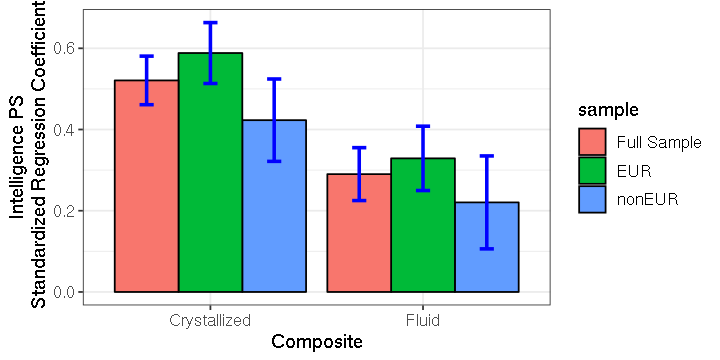

In [129]:
options(repr.plot.width=6, repr.plot.height=3)
composite_ind = (model_table$dependant_var == 'nihtbx_fluidcomp_uncorrected') | 
                (model_table$dependant_var == 'nihtbx_cryst_uncorrected')

model_table_long = gather(model_table[composite_ind, ], sample, coeff, PS_coeff_full_samp, PS_coeff_EUR, PS_coeff_nonEUR)
model_table_long_SE = gather(model_table[composite_ind, ], sample, SE, PS_coeff_SE_full_samp, PS_coeff_SE_EUR, PS_coeff_SE_nonEUR)
model_table_long$SE = model_table_long_SE$SE

#Rename vars
model_table_long$sample = str_replace(as.character(model_table_long$sample), 'PS_coeff_', '')
model_table_long$sample = str_replace(as.character(model_table_long$sample), 'full_samp', 'Full Sample')
model_table_long$sample = factor(model_table_long$sample, level=c('Full Sample', 'EUR', 'nonEUR'))
model_table_long$dependant_var = str_replace(model_table_long$dependant_var, 'nihtbx_fluidcomp_uncorrected', 'Fluid')
model_table_long$dependant_var = str_replace(model_table_long$dependant_var, 'nihtbx_cryst_uncorrected', 'Crystallized')

fp = ggplot(data=model_table_long, aes(x=dependant_var, y=coeff, fill=sample) )+
  geom_bar(position="dodge", color='black', aes(fill=sample), stat="identity") + 
geom_errorbar(data=model_table_long, mapping=aes(ymin=coeff-1.96*SE, ymax=coeff+1.96*SE), 
              position=position_dodge(.9), width=0.2, size=1, color="blue") +
xlab("Composite") + ylab('Intelligence PS\n Standardized Regression Coefficient') + theme_bw() +
theme(text = element_text(size=12)) + scale_x_discrete(labels=c("1" = "Crystallized", "2" = "Fluid"))
print(fp)
# ggsave(file='Figure_2_stratified_composite.pdf', plot=fp, height = 4 , width = 6 * aspect_ratio)

# Test Difference Between Coefficients in Two Models

We want to show a significant difference in the standardized regression coefficients of Fluid and Crysallized scales. 

Compute standard error in difference:


$$ \sigma = \sqrt{\sigma_a^2 + \sigma_b^2} $$

Then compute z-score for difference using combined standard error.

$$ Z = \frac{\beta_a - \beta_b}{\sigma}$$

Here $a$ and $b$ index fluid and crysalized composite scales.

In [327]:
z_test = function(measure_a, measure_b, sample_a, sample_b, model_table_a, model_table_b=NULL){
    if (is.null(model_table_b)){
        model_table_b = model_table_a
    }
    
    se_a = model_table_a[measure_a, paste0('PS_coeff_SE_', sample_a)]
    se_b = model_table_b[measure_b, paste0('PS_coeff_SE_', sample_b)]

    beta_a = model_table_a[measure_a, paste0('PS_coeff_', sample_a)]
    beta_b = model_table_b[measure_b, paste0('PS_coeff_', sample_b)]
    z_score = (beta_a-beta_b)/sqrt(se_a^2 + se_b^2)
    pval = 2*pnorm(-abs(z_score))
    
    measure_a = str_replace(str_replace(measure_a, 'nihtbx_', ''), '_uncorrected', '')
    measure_b = str_replace(str_replace(measure_b, 'nihtbx_', ''), '_uncorrected', '')
    cat(sprintf('Difference in regression coefficients for %s and %s p=%.3e (z=%.3f)\n', measure_a, measure_b, pval, z_score))
}

In [328]:
cat('Full Sample:\t')
z_test('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 'full_samp', 'full_samp', model_table)
cat('European Ancestry:\t')
z_test('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 'EUR', 'EUR', model_table)
cat('Admixed Ancestry:\t')
z_test('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 'nonEUR', 'nonEUR', model_table)

Full Sample:	Difference in regression coefficients for fluidcomp and cryst p=3.108e-07 (z=-5.117)
European Ancestry:	Difference in regression coefficients for fluidcomp and cryst p=3.152e-06 (z=-4.661)
Admixed Ancestry:	Difference in regression coefficients for fluidcomp and cryst p=9.438e-03 (z=-2.596)


### Difference in Regression Coefficients Between European and Non-European Samples

In [370]:
for (measure in rownames(model_table)){
    z_test(measure, measure, 'nonEUR', 'EUR', model_table)
}

Difference in regression coefficients for pattern and pattern p=5.253e-01 (z=-0.635)
Difference in regression coefficients for picture and picture p=1.834e-01 (z=-1.330)
Difference in regression coefficients for list and list p=2.278e-01 (z=-1.206)
Difference in regression coefficients for flanker and flanker p=1.281e-01 (z=-1.522)
Difference in regression coefficients for cardsort and cardsort p=7.953e-01 (z=-0.259)
Difference in regression coefficients for picvocab and picvocab p=3.191e-02 (z=-2.145)
Difference in regression coefficients for reading and reading p=4.887e-02 (z=-1.970)
Difference in regression coefficients for fluidcomp and fluidcomp p=1.266e-01 (z=-1.528)
Difference in regression coefficients for cryst and cryst p=1.019e-02 (z=-2.569)


# Total Cortical Area and Mean Thickness Associations

In [375]:
cortical_measures = c('smri_area_cort.desikan_total', 'smri_thick_cort.desikan_mean')
model_table_cort = data.frame(dependant_var=rep(cortical_measures, length(poly_score)), 
           prs=rep(poly_score, each=length(cortical_measures)))
model_table_cort$full = paste0(model_table_cort$dependant_var, ' ~ ', model_table_cort$prs, ' + ', covariate_str, ' + mri_info_device.serial.number')
model_table_cort$reduced = paste0(model_table_cort$dependant_var, ' ~ ', covariate_str, ' + mri_info_device.serial.number')

In [ ]:
model_table_cort = fit_gamm_models(dat=df, model_table=model_table_cort, suffix='_full_samp')

In [ ]:
model_table_cort = fit_gamm_models(dat=df[EUR_ind,], model_table=model_table_cort, suffix='_EUR')

In [ ]:
model_table_cort = fit_gamm_models(dat=df[!EUR_ind,], model_table=model_table_cort, suffix='_non_EUR')

In [385]:
model_table_cort[,endsWith(colnames(model_table_cort), '_full_samp')]

PS_coeff_full_samp,PS_coeff_SE_full_samp,upper_full_samp,lower_full_samp,t_full_samp,pval_full_samp,r2_delta_full_samp,lrt_chisq_full_samp,lrt_pval_full_samp,anova_full_samp,n_full_full_samp,n_reduced_full_samp
3.065738e+03,549.3868111,4.142536e+03,1.988940e+03,5.580291,2.472095e-08,0.0035132681,31.266999,2.248698e-08,51,8884,8884
7.157104e-03,0.0035713,1.415685e-02,1.573565e-04,2.004061,4.509395e-02,0.0004588218,4.029387,4.471418e-02,51,8884,8884


In [384]:
model_table_cort[,endsWith(colnames(model_table_cort), 'EUR')]

PS_coeff_EUR,PS_coeff_SE_EUR,upper_EUR,lower_EUR,t_EUR,pval_EUR,r2_delta_EUR,lrt_chisq_EUR,lrt_pval_EUR,anova_EUR,n_full_EUR,n_reduced_EUR
3739.6292559,6.903137e+02,5.092644e+03,2.386614e+03,5.417290,6.331639e-08,0.005781617,29.565003,5.407248e-08,51,5097,5097
0.0103389,4.473859e-03,1.910767e-02,1.570140e-03,2.310959,2.087522e-02,0.001058094,5.396316,2.017930e-02,51,5097,5097


In [388]:
model_table_cort[,endsWith(colnames(model_table_cort), 'non_EUR')]

PS_coeff_non_EUR,PS_coeff_SE_non_EUR,upper_non_EUR,lower_non_EUR,t_non_EUR,pval_non_EUR,r2_delta_non_EUR,lrt_chisq_non_EUR,lrt_pval_non_EUR,anova_non_EUR,n_full_non_EUR,n_reduced_non_EUR
2.258572e+03,9.385628e+02,4.098155e+03,418.9885872,2.4064151,0.01615818,1.548180e-03,5.8679609,0.0154189,51,3787,3787
-2.507849e-03,6.125024e-03,9.497199e-03,-0.0145129,-0.4094431,0.68223795,3.524812e-05,0.1754288,0.6753314,51,3787,3787
